# Moving Average, Augmented Dicky Fuller Test, GARCH

In this Notebook, we will focus on: 1) Moving average model; 2) ADFT; 3) GARCH

## Moving Average (MA)

In this part, we use AR model to predict Apple's stock price. Again, the data is from Apple.Inc (one year: from 28/Dec/2020 to 27/Dec/2021). In order to help you gain the insights of AR model, instead of using exsiting Python Statsmodels library (https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html), I tend to show an example to implement AR from scratch. Addtionally, you can use this Statsmodels library to test performance by yourself. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df=pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col=['Date'], dayfirst=True)
df.columns=['Open']
df

,Open
Date,
2020-12-28,133.990005
2020-12-29,138.050003
2020-12-30,135.580002
2020-12-31,134.080002
2021-01-04,133.520004
...,...
2021-12-20,168.279999
2021-12-21,171.559998
2021-12-22,173.039993


In [3]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Open'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_

  RMSE = np.sqrt(mean_squared_error(df_test['Open'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

From the figure of PACF, we can use 2 as the lag number.

In [4]:
lag_num = 2

## Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [5]:
[df_train,df_test,theta,intercept,RMSE] = AR(2,pd.DataFrame(df.Open))

The RMSE is : 3.2268222617815465 , Value of p :  2


In [6]:
df_c = pd.concat([df_train,df_test])
res = pd.DataFrame()

# calculate residuals based on the true open price and predicted open price


In [7]:
# plot ACF of residuals for the first 25 lags


In [8]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]

In [9]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

AttributeError: 'DataFrame' object has no attribute 'Residuals'

The RMSE is : 3.2541985735342465 , Value of q :  1
[[0.01152856]]
[0.0179795]


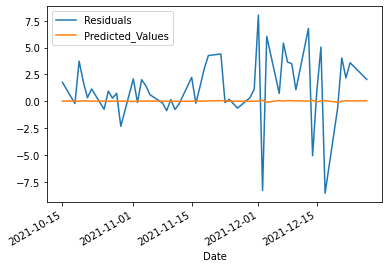

In [ ]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

3.254198573534247


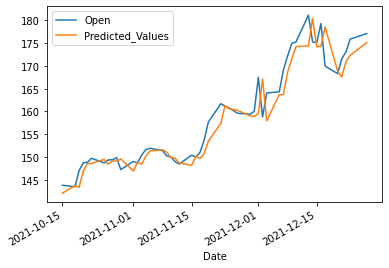

In [ ]:
df_test = df_test.iloc[1:]
df_test.Predicted_Values = df_test.Predicted_Values + res_test.Predicted_Values
df_test[['Open','Predicted_Values']].plot()
RMSE = np.sqrt(mean_squared_error(df_test['Open'], df_test['Predicted_Values']))
print(RMSE)

## Augmented Dickey–Fuller test 

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [ ]:
df_ADF = pd.read_csv('AAPL.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
adf_check(df_ADF)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.002954911878452284
p-value : 0.958287033646758
Number of Lags Used : 0
Number of Observations Used : 251
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



In [ ]:
df_ADF['Open'] = df_ADF['Open'].diff().diff()
df_ADF = df.drop(df.index[[0,1]])
df_ADF
adf_check(df)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -16.798137155426264
p-value : 1.2264852372556494e-29
Number of Lags Used : 0
Number of Observations Used : 247
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


# GARCH for Volatility Prediction

## Read Data

In [ ]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Case study: Apple stock price

In [ ]:
# set the start date and the end date you would like to study
start = datetime(2010, 1, 1)
end = datetime(2020, 6, 10)

In [ ]:
# extract data from various Internet sources into a pandas DataFrame.
# Not limited with finance data from Yahoo, it provides other popular data sources (e.g., world bank, Naver).
# See details: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
aapl = web.DataReader('AAPL', 'yahoo', start=start, end=end)

In [ ]:
# calculate volatility of returns by the function pct_change()
# For more details about why view percentage change as volatility: https://finance.zacks.com/price-change-vs-volatility-7592.html


In [ ]:
# visualise PCT return that is the percentage change from the immediately previous row by default


## PACF

In [ ]:
# calculate the PACF with the variance of return as an input


## Fit GARCH(3,3)

In [ ]:
# A GARCH model subsumes ARCH models, where a GARCH(0, q) is equivalent to an ARCH(q) model.


In [ ]:
# display model summary


# How to use the model

In [ ]:
train = returns
model = arch_model(train, p=2, q=2)
model_fit = model.fit(disp='off')

In [ ]:
from arch.__future__ import reindexing
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

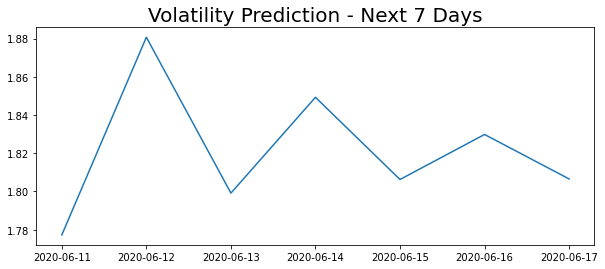

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)